In [1]:
from __future__ import annotations
from typing import TypeVar, Generic, List, Sequence
from copy import deepcopy
from functools import partial
from random import uniform
from statistics import mean,pstdev
from dataclasses import dataclass
import numpy as np
import rasterio as io
#from data_point import DataPoint

In [2]:
def zscores(original: Sequence[float]) -> List[float]:
  avg: float = mean(original)
  std: float = np.std(original)
  if std == 0: # return all zeros if there is no variation
    return [0] * len(original)
  return [(x - avg) / std for x in original]

In [3]:
from __future__ import annotations
from typing import Iterator, Tuple, List, Iterable
from math import sqrt
class DataPoint:
  def __init__(self, initial: Iterable[float]) -> None:
    self._originals: Tuple[float, ...] = tuple(initial)
    self.dimensions: Tuple[float, ...] = tuple(initial)
  @property
  def num_dimensions(self) -> int:
    return len(self.dimensions)
  def distance(self, other: DataPoint) -> float:
    combined: Iterator[Tuple[float, float]] = zip(self.dimensions,other.dimensions)
    differences: List[float] = [(x - y) ** 2 for x, y in combined]
    return sqrt(sum(differences))
  def __eq__(self, other: object) -> bool:
    if not isinstance(other, DataPoint):
      return NotImplemented
    return self.dimensions == other.dimensions
  def __repr__(self) -> str:
    return self._originals.__repr__()

In [9]:
Point = TypeVar('Point', bound=DataPoint)
class KMeans(Generic[Point]):
  @dataclass
  class Cluster:
    points: List[Point]
    centroid: DataPoint
  def __init__(self, k: int, points: List[Point]) -> None:
    if k < 1: # k-means can't do negative or zero clusters
      raise ValueError("k must be >= 1")
    self._points: List[Point] = points
    #self._zscore_normalize()
# initialize empty clusters with random centroids
    self._clusters: List[KMeans.Cluster] = []
    for _ in range(k):
      rand_point: DataPoint = self._random_point()
      cluster: KMeans.Cluster = KMeans.Cluster([], rand_point)
      self._clusters.append(cluster)
  @property
  def _centroids(self) -> List[DataPoint]:
    return [x.centroid for x in self._clusters]
  def _dimension_slice(self, dimension: int) -> List[float]:
    return [x.dimensions[dimension] for x in self._points]
  def _zscore_normalize(self) -> None:
    zscored: List[List[float]] = [[] for _ in range(len(self._points))]
    for dimension in range(self._points[0].num_dimensions):
      dimension_slice: List[float] = self._dimension_slice(dimension) #PROBLEM!!!
      for index, zscore in enumerate(zscores(dimension_slice)):
        zscored[index].append(zscore)
    for i in range(len(self._points)):
      self._points[i].dimensions = tuple(zscored[i])
  def _random_point(self) -> DataPoint:
    rand_dimensions: List[float] = []
    for dimension in range(self._points[0].num_dimensions):
      values: List[float] = self._dimension_slice(dimension)
      rand_value: float = uniform(min(values), max(values))
      rand_dimensions.append(rand_value)
    return DataPoint(rand_dimensions)
  def _assign_clusters(self) -> None:
    for point in self._points:
      closest: DataPoint = min(self._centroids,
    key=partial(DataPoint.distance, point))
      idx: int = self._centroids.index(closest)
      cluster: KMeans.Cluster = self._clusters[idx]
      cluster.points.append(point)
  def _generate_centroids(self) -> None:
    for cluster in self._clusters:
      if len(cluster.points) == 0: # keep the same centroid if no points
        continue
      means: List[float] = []
    for dimension in range(cluster.points[0].num_dimensions):
      dimension_slice: List[float] = [p.dimensions[dimension] for p in cluster.points]
      means.append(mean(dimension_slice))
      cluster.centroid = DataPoint(means)
  def run(self, max_iterations: int = 100) -> List[KMeans.Cluster]:
    for iteration in range(max_iterations):
      print(f"iteration #{iteration} centroids: {[i.centroid for i in self._clusters]}")
      for cluster in self._clusters: # clear all clusters
        cluster.points.clear()
      self._assign_clusters() # find cluster each point is closest to
      old_centroids: List[DataPoint] = deepcopy(self._centroids) # record
      self._generate_centroids() # find new centroids
      if old_centroids == self._centroids: # have centroids moved?
        print(f"Converged after {iteration} iterations")
        return self._clusters
    return self._clusters

In [11]:
point1: DataPoint = DataPoint([2.0, 1.0, 1.0])
point2: DataPoint = DataPoint([2.0, 2.0, 5.0])
point3: DataPoint = DataPoint([3.0, 1.5, 2.5])
kmeans_test: KMeans[DataPoint] = KMeans(2, [point1, point2, point3])
test_clusters: List[KMeans.Cluster] = kmeans_test.run()
for index, cluster in enumerate(test_clusters):
  print(f"Cluster {index}: {cluster.points}")

iterartion #0 centroids: [(2.2117940599146024, 1.0110417985480342, 3.751265506592531), (2.0784272159870087, 1.9082018135877137, 3.7942657021547928)]
iterartion #1 centroids: [(2.2117940599146024, 1.0110417985480342, 3.751265506592531), (2.0, 2.0, 5.0)]
Converged after 1 iterations
Cluster 0: [(2.0, 1.0, 1.0), (3.0, 1.5, 2.5)]
Cluster 1: [(2.0, 2.0, 5.0)]


In [ ]:
import imageio as io
from pathlib import Path
import os 
import numpy as np

os.chdir(r'/content/drive/MyDrive/Colab Notebooks/remotesensing')
def imgcomposite(name1,name2):
  before = io.imread(name1)
  print(f"{before} loaded with {before.shape} dimensions")
  after = io.imread(name2)
  print(f"{after} loaded with {after.shape} dimensions")
  composite = np.array([before[:,:,4],after[:,:,4]])
  pointarray = map(lambda x,y: DataPoint([x,y]),composite[0,:,:],composite[1,:,:])
  return pointarray


In [5]:

#!pip install rasterio
#!pip install geopandas
#import geopandas
import os
import rasterio
from rasterio.plot import show
os.chdir('/Users/timothyclark/Documents/Python/remote_sensing/')
file1 = 'no-0822.img'
file2 = 'no-0907.img'
class GeoPixel(DataPoint):
  def __init__(self,coord,composite):
    super().__init__(composite)
    self.coord = coord

def parser(imgfile,band):
  a = rasterio.open(imgfile)
  pixels = a.read(band)
  a.close()
  return pixels

def composite(imgarray):
  szx,szy = imgarray[0].shape[0], imgarray[0].shape[1]
  comp = np.zeros((szx,szy,len(imgarray)),dtype='int32')
  for index,band in enumerate(imgarray):
    comp[:,:,index] = band
  lst = []
  for x in range(szx):
    for y in range(szy):
      lst += [GeoPixel((x,y),list(comp[x,y,:]))]
  return lst

z = composite([parser(file1,i+1) for i in range(6)] + [parser(file2,i+1) for i in range(6)])
#z = composite([parser(file1,5),parser(file2,5),parser(file1,4)])
print(len(z))
print(z[int(uniform(0.0,float(len(z))))])

2519673
(80, 29, 25, 15, 12, 7, 70, 29, 27, 14, 10, 7)


In [10]:
#kmeans_test2: KMeans[GeoPixel] = KMeans(3,composite(parser(file1,5),parser(file2,5)))
kmeans_test2: KMeans[GeoPixel] = KMeans(5,z)
clusters: KMeans.Cluster = kmeans_test2.run()
for index, cluster in enumerate(clusters):
  print(f"Cluster {index}: {len(cluster.points)}")

iterartion #0 centroids: [(-0.6995316667182125, 19.929592688103856, 0.49313570429734455, 4.099792898373275, 1.005419058458671, 10.634959971580795, 7.956788256562868, 1.771763989482516, 14.329946428098724, 3.25900555285339, 2.918405390109664, 4.74667657968794), (-0.6810622660905308, -4.305006712287605, 7.00625108571466, 1.4206491427118624, 3.819220110248629, 8.036032957911761, 6.287704983523108, 15.721419481070093, 11.16575768398281, 7.7241325516741295, 0.7548798416810494, 11.405737829410889), (-6.501854369158625, 15.056346263400595, 1.4803496450315947, 3.1973983886725814, 1.9834239983350135, 7.524670958361323, 8.911015237654203, -2.4503547504854986, 0.9214439082150139, 4.549852624928617, 0.3746385620524759, 7.52144752693221), (5.795790353096458, 5.1792796572555915, 7.658738240489698, 4.623795584965627, 5.297158516830857, 0.9561245560141005, 8.602664505829244, 12.408729737816971, 3.786993321672608, 3.3022036405601103, 0.6171026791279943, 11.610512288060205), (0.5549127277981949, 18.5155

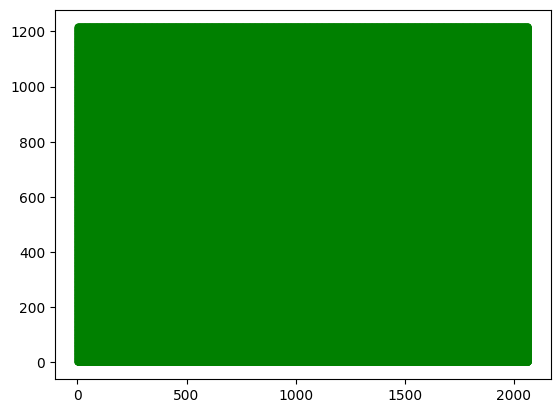

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r','b','g','k','r']
for index, cluster in enumerate(clusters):
  y = [point.coord[0] for point in cluster.points]
  x = [point.coord[1] for point in cluster.points]
  plt.scatter(x,y,marker='.',color=colors.pop())

plt.show()


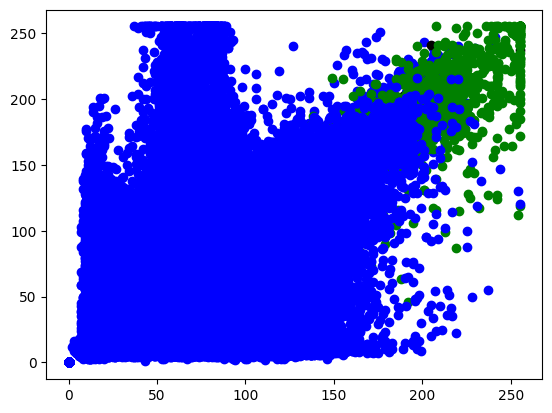

In [8]:
import matplotlib.pyplot as plt
colors = ['r','b','g','k','r','b','g','k','r','b']
for index, cluster in enumerate(clusters):
  x = [point._originals[4] for point in cluster.points]
  y = [point._originals[10] for point in cluster.points]
  plt.scatter(x,y,color=colors.pop())

plt.show()

In [26]:
import rasterio as io
#params = rasterio.open(file1,'r')
##z = parser(file1,5)
#sz = z.shape
#newraster = np.zeros((sz[0],sz[1],3),dtype='uint8')
#for index, cluster in enumerate(clusters):
#    for point in cluster.points:
#        newraster[point.coord[0],point.coord[1],index] = 255
        
def class2array(refimg,clusters,newfile):
    params = io.open(refimg,'r')
    sz = params.read(1).shape
    newraster = np.zeros((sz[0],sz[1],3),dtype=np.int8)
    for index, cluster in enumerate(clusters):
        for point in cluster.points:
            newraster[point.coord[0],point.coord[1],:]= (255/len(clusters)-1)*index
    write = io.open(f'{newfile}-kemans.tif','w',
        driver='GTiff',
        height=newraster.shape[0],
        width=newraster.shape[1],
        count=3,
        dtype=z.dtype,
        crs=params.crs,
        transform=params.transform)
    for h in range(index):
        write.write(newraster[:,:,h],h+1)
    params.close()
    write.close()
    return newraster
